In [28]:
import numpy as np
import pandas as pd
from scipy import signal, ndimage, interpolate, stats
import sys, os, time, json
from pathlib import Path
import pickle as pkl

sys.path.append('../PreProcessing/')
sys.path.append('../Lib/')
sys.path.append('../Analyses/')

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.text import Text

import TreeMazeFunctions as TMF
import spike_functions as SF
import spatial_tuning as ST
import plot_functions as PF
import TrialAnalyses as TA
import analyses_table as AT
from importlib import reload  # Python 3.4+ only.


In [8]:
oakPaths = AT.getOakPaths()

In [9]:
sns.set(style="whitegrid",font_scale=1,rc={
    'axes.spines.bottom': False,
'axes.spines.left': False,
'axes.spines.right': False,
'axes.spines.top': False,
'axes.edgecolor':'0.5'})

sns.set_context("poster")
#plotSP = Path('/mnt/c/Users/alexg8/Documents/SfN2019/Plots/')


In [ ]:
AT = reload(AT)
PF = reload(PF)
savePath = oakPaths['Analyses'] / 'PlotsByModel'
#animals = ['Li','Cl','Ne']
animals = ['Li','Cl','Ne']
tasks = ['T3h','T3g','T3j','T3i']

for an in animals:

    fn = oakPaths['Root'] / (an+'_SessionPaths.pkl')

    with fn.open(mode="rb") as f:
        sePaths = pkl.load(f)
    
    seCnt = 0
    for se in sePaths:
        if sePaths[se]['task'] in tasks:
            print('Plotting for session {}'.format(se))

            try:
                dat = AT.loadSessionData(sePaths[se])
                posdat = dat['PosDat']
                trDat = dat['TrialLongMat']
                occ = dat['za']['OccInfo']
                nCells = len(dat['ids']['cells'])
                nMua = len(dat['ids']['muas'])
                nUnits = nCells+nMua
                seCnt+=1
                #if seCnt>2:
                #    break
                for unitNum in np.arange(nUnits):
                    try:

                        if unitNum<nCells:
                            ut = 'Cell'
                            tt = dat['ids']['cells'][str(unitNum)][0]
                            cl = dat['ids']['cells'][str(unitNum)][1]
                            fr = dat['TrialFRLongMat']['cell_'+str(unitNum)]
                            wfi = dat['wfi']['Cell'][unitNum]
                            binSp = dat['bin_spikes']['Cell'][unitNum]

                            mFR = dat['wfi']['Cell'][unitNum]['mFR']
                            rZoneFR = dat['za']['FR_Zone']['Cells'][unitNum].loc['All']-mFR
                            ZoneStabFR =  dat['za']['FR_Zone']['Cells'][unitNum].loc['H1']-dat['za']['FR_Zone']['Cells'][unitNum].loc['H2']

                            tR2 = dat['fitTable2']['testR2'][unitNum]
                            selMod = dat['fitTable2']['selMod'][unitNum]

                        else:
                            ut = 'Mua'
                            muaId = unitNum-nCells
                            tt = dat['ids']['muas'][str(muaId)][0]
                            cl = dat['ids']['muas'][str(muaId)][1]
                            fr = dat['TrialFRLongMat']['mua_'+str(muaId)] 
                            wfi = dat['wfi']['Mua'][muaId]
                            binSp = dat['bin_spikes']['Mua'][muaId]

                            mFR = dat['wfi']['Mua'][muaId]['mFR']
                            rZoneFR = dat['za']['FR_Zone']['Mua'][muaId].loc['All']-mFR
                            ZoneStabFR =  dat['za']['FR_Zone']['Mua'][muaId].loc['H1']-dat['za']['FR_Zone']['Mua'][muaId].loc['H2']

                            tR2 = dat['fitTable2']['testR2'][muaID]
                            selMod = dat['fitTable2']['selMod'][muaID]


                        f = plt.figure(figsize=(20,20))

                        yorig = 0.42
                        w = 0.19
                        hsp = 0.05
                        vsp = 0.06
                        h = 0.17
                        yPos = np.array([vsp,2*vsp+h])+yorig
                        #xPos = np.arange(1,5)*hsp+np.arange(0,4)*w
                        xPos = [hsp, 2*hsp+w, 2.5*hsp+2*w, 4*hsp+3*w]
                        ax_top = {}
                        cnt=0
                        for i in np.arange(2):
                            ax_top[i] = {}
                            for j in np.arange(4):
                                ax_top[i][j]=f.add_subplot(241+cnt)
                                ax_top[i][j].set_position([xPos[j],yPos[i],w,h])
                                cnt+=1

                        PF.plotSpikeWFs(wfi,ax=ax_top[1][0])
                        PF.plotISIh(wfi,ax=ax_top[0][0])
                        ax_top[0][0].set_title('')

                        PF.plotTracesSpikes(posdat,binSp,ax=ax_top[1][1])
                        PF.plotRateMap(binSp,posdat,occ,ax=ax_top[0][1])

                        leg_ax = {'size':20}
                        _,cax = PF.plotZoneAvgMaps(rZoneFR,ax=ax_top[1][2])
                        cax.set_ylabel('rFR[sp/s]',**leg_ax)
                        for label in (cax.get_yticklabels()):
                            label.set_fontsize(10) # Size here overrides font_prop
                        ax_top[1][2].set_title('FR by Zone')

                        _,cax=PF.plotZoneAvgMaps(ZoneStabFR,vmax=5,ax=ax_top[0][2])
                        cax.set_ylabel('H1-H2 [sp/s]',**leg_ax)
                        for label in (cax.get_yticklabels()):
                            label.set_fontsize(10) # Size here overrides font_prop
                        ax_top[0][2].set_title('FR Stability')

                        PF.plotTrial_Desc(fr,trDat,ax=ax_top[0][3])
                        ax_top[0][3].set_title('FR by Desc')
                        PF.plotTrial_IO(fr,trDat,ax=ax_top[1][3])
                        ax_top[1][3].set_title('FR by Direction')

                        f,ax_bot=PF.plot_TrLinearized(fr,trDat,pos=[0.02,0.02,1,0.4],f=f)
                        ax_bot[0][2].text(1.03,0.4,'tR2={0:0.2f}'.format(tR2),transform=ax_bot[0][2].transAxes,fontsize ='medium')
                        ax_bot[0][2].text(1.03,0.3,'{}'.format(selMod),transform=ax_bot[0][2].transAxes,fontsize ='medium')
                        ax_bot[0][2].text(1.03,0.2,'{}: ID={}, tt={},cl={}'.format(ut,unitNum,tt,cl),transform=ax_bot[0][2].transAxes,fontsize ='medium')
                        ax_bot[0][2].text(1.03,0.1,se,transform=ax_bot[0][2].transAxes,fontsize ='medium')

                        sp = savePath/selMod
                        sp.mkdir(parents=True,exist_ok=True)

                        fn = '{}_ID-{}.jpeg'.format(se,unitNum)
                        f.savefig(str(sp/fn),dpi=300, bbox_inches='tight',pad_inches=0.2)
                        plt.close(f)
                    except:
                        print('Error Processing unit # {}'.format(unitNum))
                        print ("Error", sys.exc_info()[0],sys.exc_info()[1],sys.exc_info()[2].tb_lineno)

            except:
                print ("Error", sys.exc_info()[0],sys.exc_info()[1],sys.exc_info()[2].tb_lineno)

Plotting for session Li_T3g_052418
Error <class 'FileNotFoundError'> [Errno 2] No such file or directory: '/mnt/o/giocomo/alexg/Analyses/Li/Li_T3g_052418_Analyses/Cell_WaveFormInfo.pkl' 21
Plotting for session Li_T3g_052518
Error <class 'FileNotFoundError'> [Errno 2] No such file or directory: '/mnt/o/giocomo/alexg/Analyses/Li/Li_T3g_052518_Analyses/Cell_WaveFormInfo.pkl' 21
Plotting for session Li_T3g_052818
Loading Beh Tracking Data
Complete.
Error Processing unit # 4
Error <class 'NameError'> name 'muaID' is not defined 62
Error Processing unit # 5
Error <class 'NameError'> name 'muaID' is not defined 62
Error Processing unit # 6
Error <class 'NameError'> name 'muaID' is not defined 62
Error Processing unit # 7
Error <class 'NameError'> name 'muaID' is not defined 62
Error Processing unit # 8
Error <class 'NameError'> name 'muaID' is not defined 62
Error Processing unit # 9
Error <class 'NameError'> name 'muaID' is not defined 62
Error Processing unit # 10
Error <class 'NameError'> 

In [26]:
dat['fitTable2']

,ut,FullMod_tR2,modelNum,trainR2,AICc,testR2,Loc:IO,Loc,IO,Cue,Sp,Co
0,cell,0.365628,31.0,0.528257,2923.380598,0.367839,25.089237,14.894310,13.078301,NaN,NaN,NaN
1,cell,0.181413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cell,0.464102,31.0,0.765678,2261.046310,0.450354,32.053749,35.172695,29.337670,NaN,NaN,NaN
3,cell,0.181950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,cell,0.138428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,cell,0.528659,33.0,0.652049,2967.965948,0.528511,26.257382,29.082328,15.768763,NaN,4.718333,NaN
6,mua,0.037023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,mua,0.008953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,mua,0.003944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,mua,0.095548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
an = 'Li'
fn = oakPaths['Root'] / (an+'_AnalysesTable.csv')
aTable = pd.read_csv(fn,index_col=0)

fn = oakPaths['Root'] / (an+'_SessionPaths.pkl')
with fn.open(mode="rb") as f:
    sePaths = pkl.load(f)


In [416]:
def loadSessionData(sessionPaths):
    wfi = {}
    bin_spikes = {}
    fr = {}
    
    mods = {}
    params = TA.getParamSet()
    for k,pp in params.items():
        s =''
        for p in pp:
            s+='-'+p
        mods[k]=s[1:]
        
    for ut in ['Cell','Mua']:
        with sessionPaths[ut+'_WaveFormInfo'].open(mode='rb') as f:
            wfi[ut] = pkl.load(f)
        bin_spikes[ut]=np.load(sessionPaths[ut+'_Bin_Spikes'])
        fr[ut] = np.load(sessionPaths[ut+'_FR'])
    
    with sessionPaths['Spike_IDs'].open() as f:
        ids = json.load(f)
    with sessionPaths['ZoneAnalyses'].open(mode='rb') as f:
        za = pkl.load(f)
    
    PosDat = TMF.getBehTrackData(sessionPaths)
    
    TrialLongMat = pd.read_csv( sessionPaths['TrLongPosMat'],index_col=0)
    TrialFRLongMat = pd.read_csv(sessionPaths['TrLongPosFRDat'],index_col=0)
    fitTable = pd.read_csv(sessionPaths['TrModelFits'],index_col=0)
    TrialConds = pd.read_csv(sessionPaths['TrialCondMat'] ,index_col=0)

    
    if isinstance(fitTable,pd.core.frame.DataFrame):
        nUnits = fitTable.shape[0]
        x=[]
        for i in np.arange(nUnits):
            if np.isnan(fitTable['modelNum'][i]):
                x.append('UnCla')
            else:
                x.append(mods[fitTable['modelNum'][i]])
        fitTable['selMod'] = x
    
    dat = {}
    dat['wfi'] = wfi
    dat['bin_spikes'] = bin_spikes
    dat['fr'] = fr
    
    dat['ids'] = ids
    dat['za'] = za

    dat['PosDat'] = PosDat
    dat['TrialLongMat'] = TrialLongMat
    dat['TrialFRLongMat'] = TrialFRLongMat
    dat['TrialModelFits'] = fitTable
    dat['TrialConds'] = TrialConds
    
    return dat


In [911]:
se = 'Li_T3g_062718'
dat = loadSessionData(sePaths[se])

Loading Beh Tracking Data
Complete.


In [13]:
dat

{'wfi': {'Cell': {0: {'mean': array([[-1.34665255e+01, -1.25395015e+01,  5.47680404e+01,
            -9.05326600e+00],
           [-2.42425476e+01, -1.89973937e+01,  3.09972308e+01,
            -1.49345170e+01],
           [-3.87046750e+01, -3.00666232e+01,  5.03358853e+01,
            -1.03005375e+01],
           [-4.93039583e+01, -4.09841994e+01,  9.27072813e+01,
            -3.87587555e+00],
           [-5.45074116e+01, -4.97945920e+01,  1.02317804e+02,
            -6.71379704e+00],
           [-6.10583157e+01, -6.04826519e+01,  5.76333279e+01,
            -1.80535918e+01],
           [-7.49636749e+01, -7.69400554e+01,  6.56149210e+00,
            -2.40661345e+01],
           [-9.26691644e+01, -9.59519466e+01,  1.59462453e+01,
            -1.36359342e+01],
           [-1.04796384e+02, -1.09754032e+02,  8.92327741e+01,
             5.92018244e+00],
           [-1.08760710e+02, -1.16610197e+02,  1.54620459e+02,
             1.36558071e+01],
           [-1.13842157e+02, -1.25241896e+02

In [913]:
def plotSpikeWFs(wfi,plotStd=0,ax=None):
    wfm = wfi['mean']
    wfstd = wfi['std']
    
    if (ax is None):
        f,ax = plt.subplots(1,figsize=(6,4))
        
    nSamps,nChan = wfm.shape
    x = np.arange(nSamps)
    ax.plot(x,wfm,lw=3,alpha=0.9)
    ax.get_yaxis().set_ticklabels([])
    if plotStd:
        for ch in np.arange(nChan):
            plt.fill_between(x,wfm[:,ch]-wfstd[:,ch],wfm[:,ch]+wfstd[:,ch],alpha=0.1)
            
    plt.legend(['ch'+str(ch) for ch in np.arange(nChan)],loc='best',frameon=False)
    if nSamps==64:
        ax.get_xaxis().set_ticks([0,16,32,48,64])
        ax.get_xaxis().set_ticklabels(['0','','1','','2'])
        ax.set_xlabel('Time [ms]')
    ax.text(0.65,0.1,'mFR={0:.2f}[sp/s]'.format(wfi['mFR']),transform=ax.transAxes)
    ax.set_title('WaveForms')
    return ax

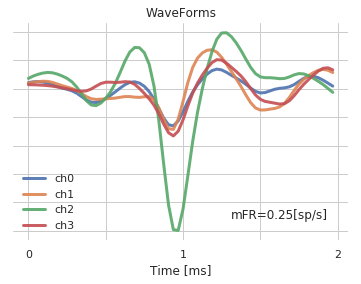

In [914]:
plotSpikeWFs(dat['wfi']['Cell'][0])

In [915]:
def plotRateMap(binSpikes, PosDat, OccInfo, cbar = False, ax=None):
    spikesByPos = ST.getPosBinSpikeMaps(binSpikes,PosDat)
    FR_ByPos = ST.getPosBinFRMaps(spikesByPos,OccInfo['time'])
    
    if (ax is None):
        f,ax = plt.subplots(1,figsize=(4,4))
    cmap = 'viridis'
    colbar_label = 'FR [sp/s]'
    smooth =  True
    robust = False
    w =4
    s=1
    ax.axis('equal')
    pos = ax.get_position()
    if cbar:
        cax = plt.axes([pos.x0+pos.width,pos.y0,0.05*pos.width,0.3*pos.height])
    if smooth:
        FR_ByPos = ST.getSmoothMap(FR_ByPos,w,s)
    maxFR = np.max(FR_ByPos)    
    with sns.plotting_context(font_scale=1):
        if cbar:
            ax=sns.heatmap(FR_ByPos.T,xticklabels=[],yticklabels=[],ax=ax,square=False, robust=robust, cbar_ax=cax, cmap=cmap,cbar_kws={'label': colbar_label})
        else:
            #ax=sns.heatmap(FR_ByPos.T,xticklabels=[],yticklabels=[],ax=ax,square=False, robust=robust, cbar=False, cmap=cmap)
            #ax=sns.heatmap(FR_ByPos.T,xticklabels=[],yticklabels=[],ax=ax,square=False, robust=robust, cbar=False, cmap=cmap)
            ax=sns.heatmap(FR_ByPos.T,xticklabels=[],yticklabels=[],ax=ax,square=True, robust=robust, cbar=False, cmap=cmap, vmin=0, vmax=maxFR*0.9)
            ax.text(0.7,0.12,'{0:.2f}[Hz]'.format(maxFR),color='w',transform=ax.transAxes)
            
        ax.invert_yaxis()
    ax.set_title('Rate Map')
    return ax

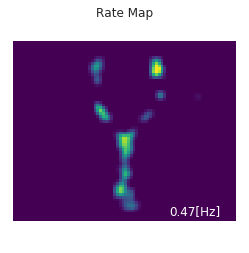

In [916]:
ax=plotRateMap(dat['bin_spikes']['Cell'][0],dat['PosDat'], dat['za']['OccInfo'])

In [917]:
def plotISIh(wfi,ax=None):
    x = wfi['isi_h'][1][1:]
    h = wfi['isi_h'][0]
    #h = h/np.sum(h)

    if (ax is None):
        f,ax = plt.subplots(1,figsize=(4,3))

    
    ax.bar(x,h,color=[0.3,0.3,0.4],alpha=0.8)
    ax.set_xlabel('ISI [ms]')
    ax.text(0.7,0.7,'CV={0:.2f}'.format(wfi['cv']),transform=ax.transAxes)
    ax.set_yticklabels([''])
    ax.set_title('ISI Hist')
    return ax
    

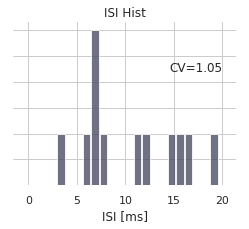

In [918]:
#plt.bar(dat['wfi']['Cell'][0]['isi_h'][1][1:],dat['wfi']['Cell'][0]['isi_h'][0])
plotISIh(dat['wfi']['Cell'][0])

In [919]:
def plotTracesSpikes(PosDat,spikes,ax=None):
    if (ax is None):
        f,ax = plt.subplots(1,figsize=(4,4))
        
    x = PosDat['x']
    y = PosDat['y']
    ax.scatter(x,y,0.2,marker='D',color=np.array([0.3,0.3,0.3])*2,alpha=0.05)
    if len(spikes)==len(x):
        ax.scatter(x,y,s=spikes, alpha=0.1, color = 'r')
    ax.set_axis_off()
    ax.set_xlim(TMF.x_limit)
    ax.set_ylim(TMF.y_limit)
    ax.set_title('Spike Traces')
    return ax

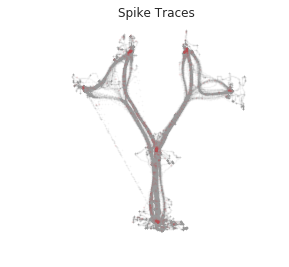

In [920]:
plotTracesSpikes(dat['PosDat'],dat['bin_spikes']['Cell'][0])
#f,ax = plt.subplots(1,figsize=(5,5))
# PF=reload(PF)
# ax=PF.plotTM_Trace(ax,dat['PosDat']['x'],dat['PosDat']['y'],bin_spikes=dat['bin_spikes']['Cell'][0], plot_raw_traces=1,plot_zones=0)

In [229]:
dat['za']['FR_Zone']['Cells'][0]

,Home,SegA,Center,SegB,I1,SegC,G1,SegD,G2,SegE,I2,SegF,G3,SegG,G4
All,0.954339,2.634274,3.165379,2.350739,2.885412,2.953722,3.794650,4.720896,4.203670,1.917758,1.543792,2.723591,3.047227,1.723778,1.890825
H1,0.844630,2.800187,3.251741,2.235300,2.853522,2.359875,3.048328,5.382514,4.573533,1.819051,1.746788,3.367845,3.774672,1.839381,2.046330
H2,1.045399,2.471026,3.048925,2.489643,2.922478,3.660021,4.590116,3.705886,3.731792,2.004020,1.398002,2.406162,2.544971,1.538487,1.668860
CL,0.953604,3.805920,4.079974,2.422791,4.097115,3.983007,3.543261,4.641293,3.788541,1.397518,1.349614,1.970063,1.875907,1.576351,1.449598
CR,1.012168,2.391468,2.118196,1.774582,2.550216,2.955989,8.545538,3.606097,2.744714,1.443077,0.767800,1.466168,2.240741,1.439683,0.683030
CO,0.852801,1.984217,2.244406,2.829922,3.030966,2.765189,2.899710,6.893349,5.467618,2.511678,2.178634,3.538660,3.357070,1.924207,2.131674
In,NaN,1.967000,NaN,2.968779,NaN,2.642451,NaN,6.652852,NaN,2.477683,NaN,3.619238,NaN,2.281630,NaN
Out,NaN,3.268342,NaN,1.866242,NaN,3.206356,NaN,2.500203,NaN,1.427336,NaN,2.039677,NaN,0.890476,NaN


In [921]:
def plotZoneAvgMaps(ZoneAct,vmax = None,ax=None):
    if (ax is None):
        f,ax = plt.subplots(1,figsize=(6,6))
        
    ax.axis('equal')
    pos = ax.get_position()
    cax = plt.axes([pos.x0+pos.width*0.78,pos.y0,0.05*pos.width,0.3*pos.height])
    
    #cDat,colArray =  PF.getDatColorMap(ZoneAct)
    #cMap = plt.get_cmap('RdBu_r')
    cMap=mpl.colors.ListedColormap(sns.diverging_palette(250, 10, s=90, l=50,  n=50, center="dark"))
    if vmax is None:
        minima = np.min(ZoneAct)
        maxima = np.max(ZoneAct)
        vmax = np.max(np.abs([minima,maxima]))
    norm = mpl.colors.Normalize(vmin=-vmax, vmax=vmax, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cMap)
    
    cnt=0
    for zo in TMF.ZonesNames:
        #PF.plotPoly(TMF.MazeZonesGeom[zo],ax,color=cDat[cnt],alpha=1)
        PF.plotPoly(TMF.MazeZonesGeom[zo],ax,color=mapper.to_rgba(ZoneAct[cnt]),alpha=1)
        
        cnt+=1
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        
    ax.set_axis_off()
    ax.set_xlim(TMF.x_limit)
    ax.set_ylim(TMF.y_limit)
    ax.axis('equal')

#     cNorm = mpl.colors.Normalize(vmin=colArray[0],vmax=colArray[-1])
#     sm = plt.cm.ScalarMappable(cmap=cMap,norm=cNorm)
    mapper.set_array([])

    cbar = plt.colorbar(mapper,cax=cax)
    cax.yaxis.set_tick_params(right=False)
    #cax.get_yticklabels().set_fontsize(10)
    
    return ax,cax

In [273]:
plt.get_cmap('RdBu_r')

Text(0.5, 1.0, 'FR by Zone')

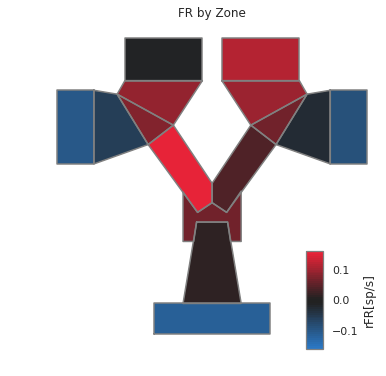

In [922]:
PF = reload(PF)
ax,cax=plotZoneAvgMaps(dat['za']['FR_Zone']['Cells'][0].loc['All']-dat['wfi']['Cell'][0]['mFR'])
cax.set_ylabel('rFR[sp/s]')
ax.set_title('FR by Zone')

Text(0.5, 1.0, 'FR Stability')

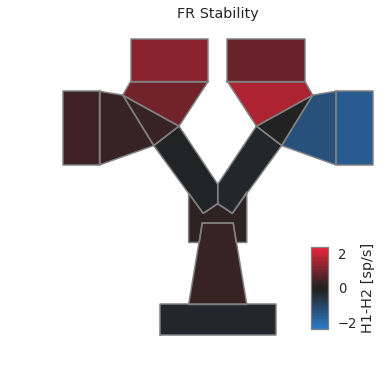

In [316]:
x = dat['za']['FR_Zone']['Cells'][0].loc['H1']
y = dat['za']['FR_Zone']['Cells'][0].loc['H2']
ax,cax=plotZoneAvgMaps(x-y,vmax=dat['wfi']['Cell'][0]['mFR'])
cax.set_ylabel('H1-H2 [sp/s]')
ax.set_title('FR Stability')

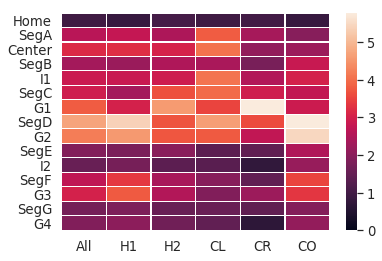

In [331]:
sns.heatmap(dat['za']['FR_Zone']['Cells'][0].loc[['All','H1','H2','CL','CR','CO']].T,vmin=0,robust=True,linewidths=0.3)

In [923]:
def plotTrial_IO(frVector,trDat,ax=None):
    if (ax is None):
        f,ax = plt.subplots(1,figsize=(4,4))
        
    cellDat = trDat.copy()
    cellDat.loc[:,'zFR'] = frVector
    subset = cellDat['Co']=='Co'
    
    dat =[]
    dat = cellDat[subset].groupby(['trID','IO','Cue','Desc']).mean()
    dat = dat.reset_index()
    
    pal = sns.xkcd_palette(['spring green','light purple'])
    with sns.color_palette(pal):
        ax=sns.violinplot(y='zFR',x='IO',hue='Desc',data=dat,split=True, ax=ax,
                          scale='count',inner='quartile',hue_order=['L','R'],saturation=0.5,order=['Out','In','O_I'])
    pal = sns.xkcd_palette(['emerald green','medium purple'])
    with sns.color_palette(pal):
        ax=sns.stripplot(y='zFR',x='IO',hue='Desc',data=dat,dodge=True,hue_order=['L','R'],alpha=0.7,ax=ax,
                         edgecolor='gray',order=['Out','In','O_I'])
        
    l=ax.get_legend()
    l.set_visible(False)
    ax.set_xlabel('Direction')
    
    return ax

In [924]:
def plotTrial_Desc(frVector,trDat,ax=None):
    if (ax is None):
        f,ax = plt.subplots(1,figsize=(4,4))
        
    cellDat = trDat.copy()
    cellDat.loc[:,'zFR'] = frVector    
    subset= cellDat['IO']=='Out'
    
    dat = []
    dat = cellDat[subset].groupby(['trID','Cue','Co','Desc']).mean()
    dat = dat.reset_index()

    pal = sns.xkcd_palette(['spring green','light purple'])
    with sns.color_palette(pal):
        ax=sns.violinplot(y='zFR',x='Desc',hue='Cue',data=dat,split=True,scale='width',ax=ax,
                          inner='quartile',order=['L','R'],hue_order=['L','R'],saturation=0.5)
    pal = sns.xkcd_palette(['emerald green','medium purple'])
    with sns.color_palette(pal):
        ax=sns.stripplot(y='zFR',x='Desc',hue='Cue',data=dat,dodge=True,order=['L','R'],ax=ax,
                            hue_order=['L','R'],alpha=0.7,edgecolor='gray')

    #
    ax.set_xlabel('Decision')
    #ax.set_ylabel('')
    
    l=ax.get_legend()
    handles, labels = ax.get_legend_handles_labels()
    l.set_visible(False)
    #plt.legend(handles[2:],labels[2:],bbox_to_anchor=(1.05, 0), borderaxespad=0.,frameon=False,title='Cue')
    
    #plt.legend(handles[2:],labels[2:],loc=(1,1), borderaxespad=0.,frameon=False,title='Cue')

    return ax,

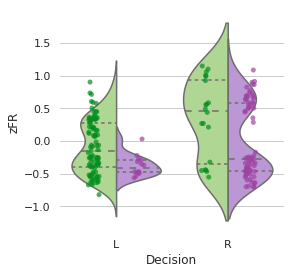

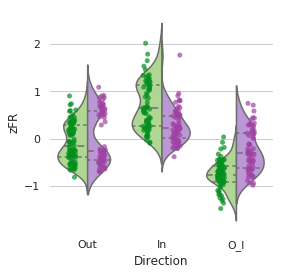

In [925]:

trDat = dat['TrialLongMat']
nCells = len(dat['ids']['cells'])
nMua = len(dat['ids']['muas'])
nUnits = nCells+nMua

unitNum = 3
cellDat = trDat.copy()
cellDat.loc[:,'zFR'] = fr

if unitNum<nCells:
    tt = dat['ids']['cells'][str(unitNum)][0]
    cl = dat['ids']['cells'][str(unitNum)][1]
    fr = dat['TrialFRLongMat']['cell_'+str(unitNum)]
    tR2 = dat['TrialModelFits']['testR2'][unitNum]
    selMod = dat['TrialModelFits']['selMod'][unitNum]
else:
    muaID = unitNum-nCells
    tt = dat['ids']['muas'][str(muaID)][0]
    cl = dat['ids']['muas'][str(muaID)][1]
    fr = dat['TrialFRLongMat']['mua_'+str(muaID)] 
    tR2 = dat['TrialModelFits']['testR2'][unitNum]
    selMod = dat['TrialModelFits']['selMod'][unitNum]

plotTrial_Desc(fr,trDat)
plotTrial_IO(fr,trDat)

In [19]:
print(dat.keys())
dat['TrialModelFits']#[['testR2','selMod']]

dict_keys(['wfi', 'bin_spikes', 'fr', 'ids', 'za', 'PosDat', 'TrialLongMat', 'TrialFRLongMat', 'TrialModelFits'])


,ut,FullMod_tR2,modelNum,trainR2,AICc,testR2,Loc:IO,Loc,IO,Cue,Desc,Co,selMod
0,cell,0.112063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnCla
1,cell,0.558580,31.0,0.630962,3298.949146,0.554684,23.461443,24.838586,1.820952,NaN,NaN,NaN,Loc:IO-Loc-IO
2,cell,0.609830,33.0,0.718256,3705.684042,0.615870,30.848068,40.206015,19.062448,NaN,5.073159,NaN,Loc:IO-Loc-IO-Desc
3,cell,0.625478,36.0,0.676778,3329.929336,0.624109,27.689482,43.623683,21.175654,5.550799,NaN,6.1731,Loc:IO-Loc-IO-Cue-Co
4,cell,0.591286,33.0,0.652010,3253.379867,0.593817,28.808417,32.457323,25.750658,NaN,6.479167,NaN,Loc:IO-Loc-IO-Desc
5,mua,0.031192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnCla
6,mua,0.078649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnCla
7,mua,0.022683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnCla
8,mua,0.000071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnCla
9,mua,0.120726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UnCla


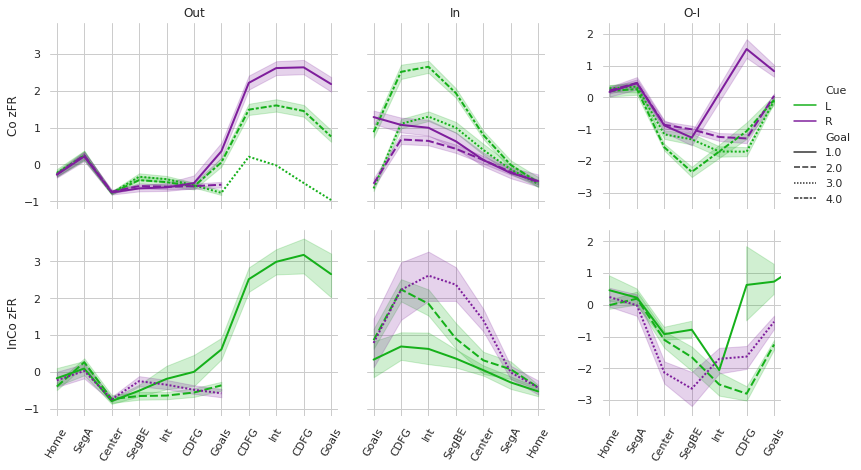

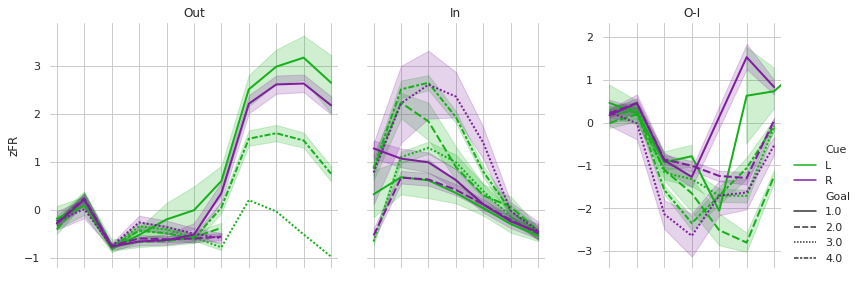

In [926]:

#f = plt.figure(figsize=(18,18))
#f,ax = plt.subplots(2,4, figsize=(18,18))

#f,ax_bot=plot_TrLinearized(fr,trDat,pos=[0.02,0.02,1,0.4],f=f)
f,ax_bot=plot_TrLinearized(fr,trDat)
f,ax_bot=plot_TrLinearizedCue(fr,trDat)


# ax_bot[0][2].text(1.03,0.4,'tR2={0:0.2f}'.format(tR2),transform=ax[0][2].transAxes,fontsize ='x-small')
# ax_bot[0][2].text(1.03,0.3,'{}'.format(selMod),transform=ax[0][2].transAxes,fontsize ='xx-small')
# ax_bot[0][2].text(1.03,0.2,'tt={},cl={}'.format(tt,cl),transform=ax[0][2].transAxes,fontsize ='xx-small')
# ax_bot[0][2].text(1.03,0.1,se,transform=ax[0][2].transAxes,fontsize ='xx-small')



In [927]:


trDat = dat['TrialLongMat']
trConds = dat['TrialConds']
cellDat = trDat.copy()
nCells = len(dat['ids']['cells'])
nMua = len(dat['ids']['muas'])
nUnits = nCells+nMua

unitNum = 10

if unitNum<nCells:
    tt = dat['ids']['cells'][str(unitNum)][0]
    cl = dat['ids']['cells'][str(unitNum)][1]
    fr = dat['TrialFRLongMat']['cell_'+str(unitNum)]
    tR2 = dat['TrialModelFits']['testR2'][unitNum]
    selMod = dat['TrialModelFits']['selMod'][unitNum]
else:
    muaID = unitNum-nCells
    tt = dat['ids']['muas'][str(muaID)][0]
    cl = dat['ids']['muas'][str(muaID)][1]
    fr = dat['TrialFRLongMat']['mua_'+str(muaID)] 
    tR2 = dat['TrialModelFits']['testR2'][unitNum]
    selMod = dat['TrialModelFits']['selMod'][unitNum]

cellDat.loc[:,'zFR'] = fr


goals=  np.arange(1,5)
Stem = ['Home','SegA','Center']
L_Arm = ['SegE', 'I2', 'SegF', 'G3', 'SegG', 'G4']
R_Arm = ['SegB', 'I1', 'SegC', 'G1', 'SegD', 'G2']

locs = TMF.ZonesNames
X=pd.DataFrame(np.zeros((4,len(locs))),index=goals,columns=locs)
Y={}

for goal in goals:
    Y[goal]={}
    for loc in locs:
        
        x = cellDat[(trDat['Goal']==goal) & (trDat['Loc']==loc) & (trDat['Cue']=='R') & (trDat['IO']=='Out') & (trDat['Valid'])]['zFR']
        y = cellDat[(trDat['Goal']==goal) & (trDat['Loc']==loc) & (trDat['Cue']=='L') & (trDat['IO']=='Out') & (trDat['Valid'])]['zFR']
        
        Y[goal][loc] = {}
        Y[goal][loc]['L'] = y
        Y[goal][loc]['R'] = x
        X.loc[goal,loc]=stats.ttest_ind(x,y)[0]      # positive R>L, negative L>R

Z = {'Stem':{'LCue':[],'RCue':[],'T':0},'Left':{'LCue':[],'RCue':[],'T':0},'Right':{'LCue':[],'RCue':[],'T':0}}
D = {'LDesc':[],'RDesc':[],'T':0}
for loc in locs:
    x = cellDat[(trDat['Loc']==loc) & (trDat['Cue']=='R') & (trDat['IO']=='Out') & (trDat['Valid'])]['zFR']
    y = cellDat[(trDat['Loc']==loc) & (trDat['Cue']=='L') & (trDat['IO']=='Out') & (trDat['Valid'])]['zFR']
    if loc in Stem:
        Z['Stem']['RCue']+=x.tolist()
        Z['Stem']['LCue']+=y.tolist()
    elif loc in L_Arm:
        Z['Left']['RCue']+=x.tolist()
        Z['Left']['LCue']+=y.tolist()
    else:
        Z['Right']['RCue']+=x.tolist()
        Z['Right']['LCue']+=y.tolist()
    
    x = cellDat[(trDat['Loc']==loc) & (trDat['Desc']=='R') & (trDat['IO']=='Out') & (trDat['Valid'])]['zFR']
    y = cellDat[(trDat['Loc']==loc) & (trDat['Desc']=='L') & (trDat['IO']=='Out') & (trDat['Valid'])]['zFR']
    if loc in Stem:
        D['RDesc']+=x.tolist()
        D['LDesc']+=y.tolist()
        
for part in ['Stem','Left','Right']:
    x = np.array(Z[part]['RCue'])
    y = np.array(Z[part]['LCue'])
    if (len(x)>=5) & (len(y)>=5):
        Z[part]['T'] = stats.ttest_ind(x,y)[0]
    else:
        Z[part]['T'] = np.nan

D['T'] = stats.ttest_ind(D['RDesc'],D['LDesc'])

for i,row in cellDat.iterrows():
    if row['Loc'] in Stem:
        cellDat.loc[i,'Part'] = 'Stem'
    elif row['Loc'] in L_Arm:
        cellDat.loc[i,'Part'] = 'L_Arm'
    elif row['Loc'] in R_Arm:
        cellDat.loc[i,'Part'] = 'R_Arm'
        

In [420]:
trConds

,Cues,Desc,Co,Traj,OTraj,Dur,Good,Length,OLength
1,L,R,InCo,NaN,NaN,693,False,NaN,NaN
2,L,L,Co,L_S3,NaN,620,True,S,NaN
3,L,L,Co,L_L3,NaN,698,True,L,NaN
4,L,R,InCo,R_L1,R_S1,507,True,L,S
5,L,R,InCo,R_S2,R_S2,594,True,S,S
6,L,L,Co,L_L3,L_S3,633,True,L,S
7,L,L,Co,L_S4,L_S4,417,True,S,S
8,R,R,Co,R_S2,R_S2,315,True,S,S
9,R,R,Co,R_L1,R_S1,669,True,L,S
10,R,R,Co,R_L2,R_S2,475,True,L,S


              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    zFR      
No. Observations:     390        Method:                REML     
No. Groups:           195        Scale:                 0.1258   
Min. group size:      2          Likelihood:            -180.3529
Max. group size:      2          Converged:             Yes      
Mean group size:      2.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.165    0.039  4.181 0.000  0.088  0.242
Part[T.R_Arm]           1.186    0.092 12.828 0.000  1.005  1.367
Part[T.Stem]           -0.421    0.050 -8.354 0.000 -0.520 -0.322
Cue[T.R]                0.534    0.108  4.966 0.000  0.323  0.745
Part[T.R_Arm]:Cue[T.R] -0.653    0.143 -4.554 0.000 -0.933 -0.372
Part[T.Stem]:Cue[T.R]  -

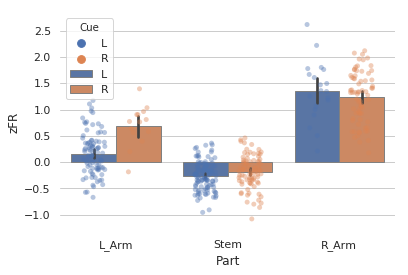

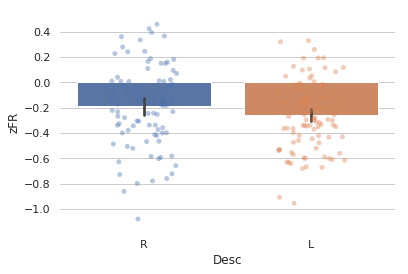

In [928]:
subset = (cellDat['IO']=='Out')
dat2 = cellDat[subset].groupby(['trID','Cue','Part']).mean()
dat2=dat2.reset_index()

import statsmodels.formula.api as smf

md =smf.mixedlm('zFR~Part*Cue',data=dat2,groups=dat2['trID'])
mdf = md.fit()
print(mdf.summary())
print(mdf.wald_test_terms())
sns.stripplot(y='zFR',x='Part',hue='Cue',data=dat2,dodge=True,hue_order=['L','R'],order = ['L_Arm','Stem','R_Arm'],alpha=0.4,edgecolor='gray',jitter=0.2)
sns.barplot(y='zFR',x='Part',hue='Cue',data=dat2,dodge=True,hue_order=['L','R'],order = ['L_Arm','Stem','R_Arm'],edgecolor='gray')


subset = (cellDat['IO']=='Out') & (cellDat['Part']=='Stem')
dat2 = cellDat[subset].groupby(['trID','Desc']).mean()
dat2=dat2.reset_index()
md =smf.mixedlm('zFR~Desc',data=dat2,groups=dat2['trID'])
mdf = md.fit()

print(mdf.summary())
print(mdf.wald_test_terms())

plt.figure()
sns.stripplot(y='zFR',x='Desc',data=dat2,dodge=True,alpha=0.4,edgecolor='gray',jitter=0.2)
sns.barplot(y='zFR',x='Desc',data=dat2,dodge=True)


In [875]:
Trials = np.array(trConds[trConds['Good']].index)
nTrials = len(Trials)
CoTrials = np.array(trConds[(trConds['Good']) & (trConds['Co']=='Co')].index)
InCoTrials = np.array(trConds[(trConds['Good']) & (trConds['Co']=='InCo')].index)

TrSets = {}
TrSets['all'] = np.arange(len(Trials))
_,idx,_=np.intersect1d(np.array(Trials),np.array(CoTrials),return_indices=True)
TrSets['co'] = idx
_,idx,_=np.intersect1d(np.array(Trials),np.array(InCoTrials),return_indices=True)
TrSets['inco'] = idx

cueVec = trConds.loc[trConds['Good']]['Cues'].values
descVec = trConds.loc[trConds['Good']]['Desc'].values
predVec = {'Cue':cueVec, 'Desc':descVec}

# data partitions: ha-> home and segA; stem-> home, segA, center; g-> up to the first goal well 
nFeatures = {'ha':np.arange(2),'stem':np.arange(3),'g':np.arange(7)}
zoneFR = pd.DataFrame(np.zeros((nTrials,7)))

for t in np.arange(nTrials):
    subset = (cellDat['trID']==Trials[t]) & (cellDat['IO']=='Out') 
    zoneFR.iloc[t] = cellDat[subset]['zFR'].values[:7]
        

In [56]:
def plot_TrLinearizedCue(fr,trDat,pos=None,f=None):
   
    alpha=0.15
    mlw = 1
    nMaxPos = 11
    nMinPos = 7
    plotAll = False
    
    cellDat = trDat.copy()
    cellDat.loc[:,'zFR'] = fr

    if (pos is None) or (f is None):
        f,ax = plt.subplots(1,3, figsize=(16,4))
        yorig = 0
        xorig = 0
        yscale = 1
        xscale = 1
    else:
        xorig,yorig,xscale,yscale = pos
        ax={}
        #f.add_subplot()
        cnt=0
        for j in np.array(3):
            #ax[i][j] = f.add_axes([0,0,1,1,])
            ax[j] = f.add_subplot(131+cnt)
            cnt+=1
          
    w = 0.25*xscale
    ratio = 6.5/10.5
    hsp = 0.05*xscale
    vsp = 0.05*yscale
    h = 0.85*yscale
    W = [w,w*ratio,w*ratio]
    yPos = vsp+yorig
    xPos = np.array([hsp,1.5*hsp+W[0],2.5*hsp+W[1]+W[0]])+xorig
    #print(xPos,yPos)

    xlims = [[-0.25,10.25],[3.75,10.25],[-0.25,6.25]]
    for j in np.arange(3):
        ax[j].set_position([xPos[j],yPos,W[j],h])
        ax[j].set_xlim(xlims[j])

    xPosLabels = {}
    xPosLabels[0] = ['Home','SegA','Center','SegBE','Int','CDFG','Goals','CDFG','Int','CDFG','Goals']
    xPosLabels[2] = ['Home','SegA','Center','SegBE','Int','CDFG','Goals']
    xPosLabels[1] = xPosLabels[2][::-1]

    pal = sns.xkcd_palette(['green','purple'])
    
    with sns.color_palette(pal):

        leg='brief'

        subset = (cellDat['IO']=='Out')  & (cellDat['Valid'])
        ax[0] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',data=cellDat[subset],
                              ax=ax[0],lw=2,legend=False,hue_order=['L','R'])#,style_order=['1','2','3','4'])
        subset = (cellDat['IO']=='In') & (cellDat['Pos']>=4) & (cellDat['Valid'])
        ax[1] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',data=cellDat[subset],
                             ax=ax[1],lw=2,legend=False,hue_order=['L','R'])#,style_order=['1','2','3','4'])
        subset = (cellDat['IO']=='O_I') & (cellDat['Valid'])
        ax[2] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',data=cellDat[subset],
                             ax=ax[2],legend=leg,lw=2,hue_order=['L','R'])#,style_order=['1','2','3','4'])

        ax[1].set_xticks(np.arange(4,nMaxPos))
        ax[0].set_xticks(np.arange(nMaxPos))
        ax[2].set_xticks(np.arange(nMinPos))

        for j in np.arange(3):
            ax[j].set_xlabel('')
            ax[j].set_ylabel('')
            ax[j].tick_params(axis='x', rotation=60)

        ax[0].set_ylabel('zFR')
        ax[1].set_yticklabels('')

        for j in np.arange(3):
            ax[j].set_xticklabels(xPosLabels[j])
            ax[j].set_xticklabels('')
            
        ax[0].set_title('Out')
        ax[1].set_title('In')
        ax[2].set_title('O-I')
               
        l =ax[2].get_legend()
        plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0.,frameon=False)
        l.set_frame_on(False)

        # out/in limits
        lims = np.zeros((2,2))
        cnt =0
        for j in [0,1]:
            lims[cnt]=np.array(ax[j].get_ylim())
            cnt+=1
        minY = np.floor(np.min(lims)*20)/20
        maxY = np.ceil(np.max(lims)*20)/20
        for j in [0,1]:
            ax[j].set_ylim([minY,maxY])
        
        return f,ax

In [25]:
def plot_TrLinearized(fr,trDat,pos=None,f=None):
   
    alpha=0.15
    mlw = 1
    nMaxPos = 11
    nMinPos = 7
    plotAll = False
    
    cellDat = trDat.copy()
    cellDat.loc[:,'zFR'] = fr

    if (pos is None) or (f is None):
        f,ax = plt.subplots(2,3, figsize=(16,6))
        yorig = 0
        xorig = 0
        yscale = 1
        xscale = 1
    else:
        xorig,yorig,xscale,yscale = pos
        ax={}
        #f.add_subplot()
        cnt=0
        for i in [0,1]:
            ax[i]={}
            for j in [0,1,2]:
                #ax[i][j] = f.add_axes([0,0,1,1,])
                ax[i][j] = f.add_subplot(231+cnt)
                cnt+=1
        
        
    w = 0.25*xscale
    ratio = 6.5/10.5
    hsp = 0.05*xscale
    vsp = 0.05*yscale
    h = 0.43*yscale
    W = [w,w*ratio,w*ratio]
    yPos = np.array([vsp,2*vsp+h])+yorig
    xPos = np.array([hsp,1.5*hsp+W[0],2.5*hsp+W[1]+W[0]])+xorig
    #print(xPos,yPos)

    xlims = [[-0.25,10.25],[3.75,10.25],[-0.25,6.25]]
    for i in [0,1]:
        for j in np.arange(3):
            ax[i][j].set_position([xPos[j],yPos[i],W[j],h])
            ax[i][j].set_xlim(xlims[j])

    xPosLabels = {}
    xPosLabels[0] = ['Home','SegA','Center','SegBE','Int','CDFG','Goals','CDFG','Int','CDFG','Goals']
    xPosLabels[2] = ['Home','SegA','Center','SegBE','Int','CDFG','Goals']
    xPosLabels[1] = xPosLabels[2][::-1]

    pal = sns.xkcd_palette(['green','purple'])
    
    with sns.color_palette(pal):
        coSets = ['InCo','Co']
        for i in [0,1]:
            if i==0:
                leg=False
            else:
                leg='brief'

            if plotAll:
                subset = (cellDat['IO']=='Out') & (cellDat['Co']==coSets[i]) & (cellDat['Valid'])
                ax[i][0] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',ci=None,data=cellDat[subset],
                         ax=ax[i][0],legend=False,lw=3,hue_order=['L','R'],style_order=['1','2','3','4'])
                ax[i][0] = sns.lineplot(x='Pos',y='zFR',hue='Desc',estimator=None,units='trID',data=cellDat[subset],
                        ax=ax[i][0],legend=False,lw=mlw,alpha=alpha,hue_order=['L','R'])

                subset = (cellDat['IO']=='In') & (cellDat['Co']==coSets[i]) & (cellDat['Pos']>=4) & (cellDat['Valid'])
                ax[i][1] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',ci=None,data=cellDat[subset],
                         ax=ax[i][1],legend=False,lw=3,hue_order=['L','R'],style_order=['1','2','3','4'])
                ax[i][1] = sns.lineplot(x='Pos',y='zFR',hue='Cue',estimator=None,units='trID',data=cellDat[subset],
                        ax=ax[i][1],legend=False,lw=mlw,alpha=alpha,hue_order=['L','R'])

                subset = (cellDat['IO']=='O_I') & (cellDat['Co']==coSets[i])& (cellDat['Valid'])
                ax[i][2] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',ci=None,data=cellDat[subset],
                            ax=ax[i][2],legend=leg,lw=3,hue_order=['L','R'],style_order=['1','2','3','4'])
                ax[i][2] = sns.lineplot(x='Pos',y='zFR',hue='Cue',estimator=None,units='trID',data=cellDat[subset],
                             ax=ax[i][2],legend=False,lw=mlw,alpha=alpha,hue_order=['L','R'])

            else:
                subset = (cellDat['IO']=='Out') & (cellDat['Co']==coSets[i]) & (cellDat['Valid'])
                ax[i][0] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',data=cellDat[subset],
                                      ax=ax[i][0],lw=2,legend=False,hue_order=['L','R'])#,style_order=['1','2','3','4'])
                subset = (cellDat['IO']=='In') & (cellDat['Co']==coSets[i]) & (cellDat['Pos']>=4) & (cellDat['Valid'])
                ax[i][1] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',data=cellDat[subset],
                                     ax=ax[i][1],lw=2,legend=False,hue_order=['L','R'])#,style_order=['1','2','3','4'])
                subset = (cellDat['IO']=='O_I') & (cellDat['Co']==coSets[i])& (cellDat['Valid'])
                ax[i][2] = sns.lineplot(x='Pos',y='zFR',hue='Cue',style='Goal',data=cellDat[subset],
                                     ax=ax[i][2],legend=leg,lw=2,hue_order=['L','R'])#,style_order=['1','2','3','4'])

            ax[i][1].set_xticks(np.arange(4,nMaxPos))
            ax[i][0].set_xticks(np.arange(nMaxPos))
            ax[i][2].set_xticks(np.arange(nMinPos))

            for j in np.arange(3):
                ax[i][j].set_xlabel('')
                ax[i][j].set_ylabel('')
                ax[i][j].tick_params(axis='x', rotation=60)

            ax[i][0].set_ylabel('{} zFR'.format(coSets[i]))
            ax[i][1].set_yticklabels('')

            if i==0:
                for j in np.arange(3):
                    ax[i][j].set_xticklabels(xPosLabels[j])
            else:
                ax[i][0].set_title('Out')
                ax[i][1].set_title('In')
                ax[i][2].set_title('O-I')
                for j in np.arange(3):
                    ax[i][j].set_xticklabels('')
        l =ax[1][2].get_legend()
        plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0.,frameon=False)
        l.set_frame_on(False)

        # out/in limits
        lims = np.zeros((4,2))
        cnt =0
        for i in [0,1]:
            for j in [0,1]:
                lims[cnt]=np.array(ax[i][j].get_ylim())
                cnt+=1
        minY = np.floor(np.min(lims[:,0])*20)/20
        maxY = np.ceil(np.max(lims[:,1]*20))/20
        for i in [0,1]:
            for j in [0,1]:
                ax[i][j].set_ylim([minY,maxY])

        # o-i limits
        lims = np.zeros((2,2))
        cnt =0
        for i in [0,1]:
            lims[cnt]=np.array(ax[i][2].get_ylim())
            cnt+=1
        minY = np.floor(np.min(lims[:,0])*20)/20
        maxY = np.ceil(np.max(lims[:,1]*20))/20
        for i in [0,1]:
            ax[i][2].set_ylim([minY,maxY])
        
        return f,ax

In [ ]:
def plotTrialConds2(frDat,trDat,fitTable,savePath):

    cellColIDs =  [i for i,item in enumerate(frDat.columns.values) if 'cell' in item]
    nCells = len(cellColIDs)
    muaColIDs =  [i for i,item in enumerate(frDat.columns.values) if 'mua' in item]
    nMua = len(muaColIDs)
    nTotalUnits = nCells+nMua
    nUnits = {'cell':nCells,'mua':nMua}

    cellCols = frDat.columns[cellColIDs]
    muaCols = frDat.columns[muaColIDs]
    unitCols = {'cell':cellCols,'mua':muaCols}

    sns.set()
    sns.set(style="whitegrid",context='notebook',font_scale=1.5,rc={
        'axes.spines.bottom': False,
        'axes.spines.left': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'axes.edgecolor':'0.5'})

    cellDat = trDat.copy()
    c_cnt = -1
    for ut in ['cell','mua']:
        for cell in np.arange(nUnits[ut]):
            c_cnt+=1
            if fitTable['selMod'].iloc[c_cnt]!='UnCla':
                sm = fitTable['selMod'].iloc[c_cnt]
                tR2 = fitTable['testR2'].iloc[c_cnt]
                se = fitTable['se'].iloc[c_cnt]
                print(ut,cell,c_cnt,sm,tR2,se)
                
                print('\nPlotting {} {} {}'.format(ut,cell,sm))
                
                cellDat.loc[:,'zFR'] = frDat[unitCols[ut][cell]]

                f,ax = plt.subplots(1,2, figsize=(10,4))

                # Correct Trials Out/In O_I
                subset = cellDat['Co']=='Co'
                dat =[]
                dat = cellDat[subset].groupby(['trID','IO','Cue','Desc']).mean()
                dat = dat.reset_index()

                pal = sns.xkcd_palette(['spring green','light purple'])
                with sns.color_palette(pal):
                    ax[0]=sns.violinplot(y='zFR',x='IO',hue='Desc',data=dat,split=True, ax=ax[0],
                                      scale='count',inner='quartile',hue_order=['L','R'],saturation=0.5,order=['Out','In','O_I'])
                pal = sns.xkcd_palette(['emerald green','medium purple'])
                with sns.color_palette(pal):
                    ax[0]=sns.swarmplot(y='zFR',x='IO',hue='Desc',data=dat,dodge=True,hue_order=['L','R'],alpha=0.7,ax=ax[0],
                                     edgecolor='gray',order=['Out','In','O_I'])
                l=ax[0].get_legend()
                l.set_visible(False)
                ax[0].set_xlabel('Direction')

                #
                subset= cellDat['IO']=='Out'
                dat = []
                dat = cellDat[subset].groupby(['trID','Cue','Co','Desc']).mean()
                dat = dat.reset_index()

                pal = sns.xkcd_palette(['spring green','light purple'])
                with sns.color_palette(pal):
                    ax[1]=sns.violinplot(y='zFR',x='Desc',hue='Cue',data=dat,split=True,scale='width',ax=ax[1],
                                      inner='quartile',order=['L','R'],hue_order=['L','R'],saturation=0.5)
                pal = sns.xkcd_palette(['emerald green','medium purple'])
                with sns.color_palette(pal):
                    ax[1]=sns.swarmplot(y='zFR',x='Desc',hue='Cue',data=dat,dodge=True,order=['L','R'],ax=ax[1],
                                        hue_order=['L','R'],alpha=0.7,edgecolor='gray')

                #
                ax[1].set_xlabel('Decision')
                ax[1].set_ylabel('')
                l=ax[1].get_legend()
                handles, labels = ax[1].get_legend_handles_labels()
                l.set_visible(False)
                plt.legend(handles[2:],labels[2:],bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0.,frameon=False,title='Cue')

                
                txtstr = 'SelMod \n{0} \n\n tR2={1:.2f}'.format(sm,tR2)
                f.text(0.9,0.65,txtstr,fontsize=10)
                
                sp = savePath/sm
                sp.mkdir(parents=True,exist_ok=True)

                fn = 'TrialConds_{}_{}_ID-{}.jpeg'.format(se,ut,cell)
                f.savefig(str(sp/fn),dpi=150, bbox_inches='tight',pad_inches=0.2)
                plt.close(f)

NameError: name 'savePath' is not defined

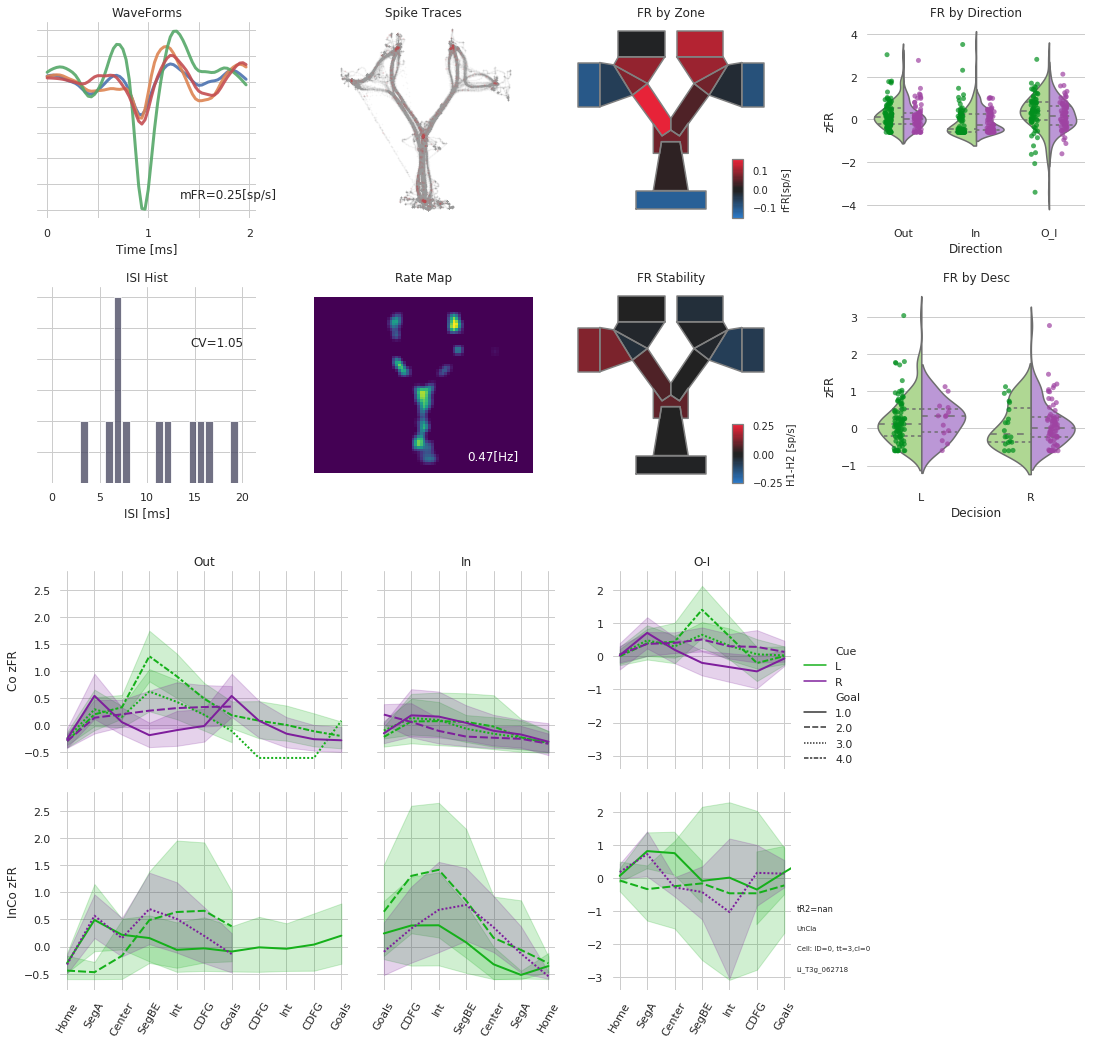

In [929]:
posdat = dat['PosDat']
trDat = dat['TrialLongMat']
occ = dat['za']['OccInfo']
nCells = len(dat['ids']['cells'])
nMua = len(dat['ids']['muas'])
nUnits = nCells+nMua


for unitNum in np.arange(nUnits):

    if unitNum<nCells:
        ut = 'Cell'
        tt = dat['ids']['cells'][str(unitNum)][0]
        cl = dat['ids']['cells'][str(unitNum)][1]
        fr = dat['TrialFRLongMat']['cell_'+str(unitNum)]
        wfi = dat['wfi']['Cell'][unitNum]
        binSp = dat['bin_spikes']['Cell'][unitNum]

        mFR = dat['wfi']['Cell'][unitNum]['mFR']
        rZoneFR = dat['za']['FR_Zone']['Cells'][unitNum].loc['All']-mFR
        ZoneStabFR =  dat['za']['FR_Zone']['Cells'][unitNum].loc['H1']-dat['za']['FR_Zone']['Cells'][unitNum].loc['H2']


        tR2 = dat['TrialModelFits']['testR2'][unitNum]
        selMod = dat['TrialModelFits']['selMod'][unitNum]

    else:
        ut = 'Mua'
        muaId = unitNum-nCells
        tt = dat['ids']['muas'][str(muaId)][0]
        cl = dat['ids']['muas'][str(muaId)][1]
        fr = dat['TrialFRLongMat']['mua_'+str(muaId)] 
        wfi = dat['wfi']['Mua'][muaId]
        binSp = dat['bin_spikes']['Mua'][muaId]


        mFR = dat['wfi']['Mua'][unitNum]['mFR']
        rZoneFR = dat['za']['FR_Zone']['Mua'][muaId].loc['All']-mFR
        ZoneStabFR =  dat['za']['FR_Zone']['Mua'][muaId].loc['H1']-dat['za']['FR_Zone']['Mua'][muaId].loc['H2']

        tR2 = dat['TrialModelFits']['testR2'][unitNum]
        selMod = dat['TrialModelFits']['selMod'][unitNum]


    f = plt.figure(figsize=(16,16))

    sns.set(style="whitegrid",font_scale=1,rc={
        'axes.spines.bottom': False,
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.edgecolor':'0.5'})


    yorig = 0.42
    w = 0.19
    hsp = 0.05
    vsp = 0.06
    h = 0.17
    yPos = np.array([vsp,2*vsp+h])+yorig
    #xPos = np.arange(1,5)*hsp+np.arange(0,4)*w
    xPos = [hsp, 2*hsp+w, 2.5*hsp+2*w, 4*hsp+3*w]
    ax_top = {}
    cnt=0
    for i in np.arange(2):
        ax_top[i] = {}
        for j in np.arange(4):
            ax_top[i][j]=f.add_subplot(241+cnt)
            ax_top[i][j].set_position([xPos[j],yPos[i],w,h])
            cnt+=1
            #
            #print([xPos[j],yPos[i],W[j],h])


    plotSpikeWFs(wfi,ax=ax_top[1][0])
    plotISIh(wfi,ax=ax_top[0][0])

    plotTracesSpikes(posdat,binSp,ax=ax_top[1][1])
    plotRateMap(binSp,posdat,occ,ax=ax_top[0][1])

    leg_ax = {'size':10}
    _,cax=plotZoneAvgMaps(rZoneFR,ax=ax_top[1][2])
    cax.set_ylabel('rFR[sp/s]',**leg_ax)
    for label in (cax.get_yticklabels()):
        label.set_fontsize(10) # Size here overrides font_prop
    ax_top[1][2].set_title('FR by Zone')

    _,cax=plotZoneAvgMaps(ZoneStabFR,vmax=mFR,ax=ax_top[0][2])
    cax.set_ylabel('H1-H2 [sp/s]',**leg_ax)
    for label in (cax.get_yticklabels()):
        label.set_fontsize(10) # Size here overrides font_prop
    ax_top[0][2].set_title('FR Stability')

    plotTrial_Desc(fr,trDat,ax=ax_top[0][3])
    ax_top[0][3].set_title('FR by Desc')
    plotTrial_IO(fr,trDat,ax=ax_top[1][3])
    ax_top[1][3].set_title('FR by Direction')

    f,ax_bot=plot_TrLinearized(fr,trDat,pos=[0.02,0.02,1,0.4],f=f)
    ax_bot[0][2].text(1.03,0.4,'tR2={0:0.2f}'.format(tR2),transform=ax_bot[0][2].transAxes,fontsize ='x-small')
    ax_bot[0][2].text(1.03,0.3,'{}'.format(selMod),transform=ax_bot[0][2].transAxes,fontsize ='xx-small')
    ax_bot[0][2].text(1.03,0.2,'{}: ID={}, tt={},cl={}'.format(ut,unitNum,tt,cl),transform=ax_bot[0][2].transAxes,fontsize ='xx-small')
    ax_bot[0][2].text(1.03,0.1,se,transform=ax_bot[0][2].transAxes,fontsize ='xx-small')

    sp = savePath/selMod
    sp.mkdir(parents=True,exist_ok=True)

    fn = '{}_ID-{}.jpeg'.format(se,unitNum)
    f.savefig(str(sp/fn),dpi=150, bbox_inches='tight',pad_inches=0.2)
    plt.close(f)

NameError: name 'savePath' is not defined

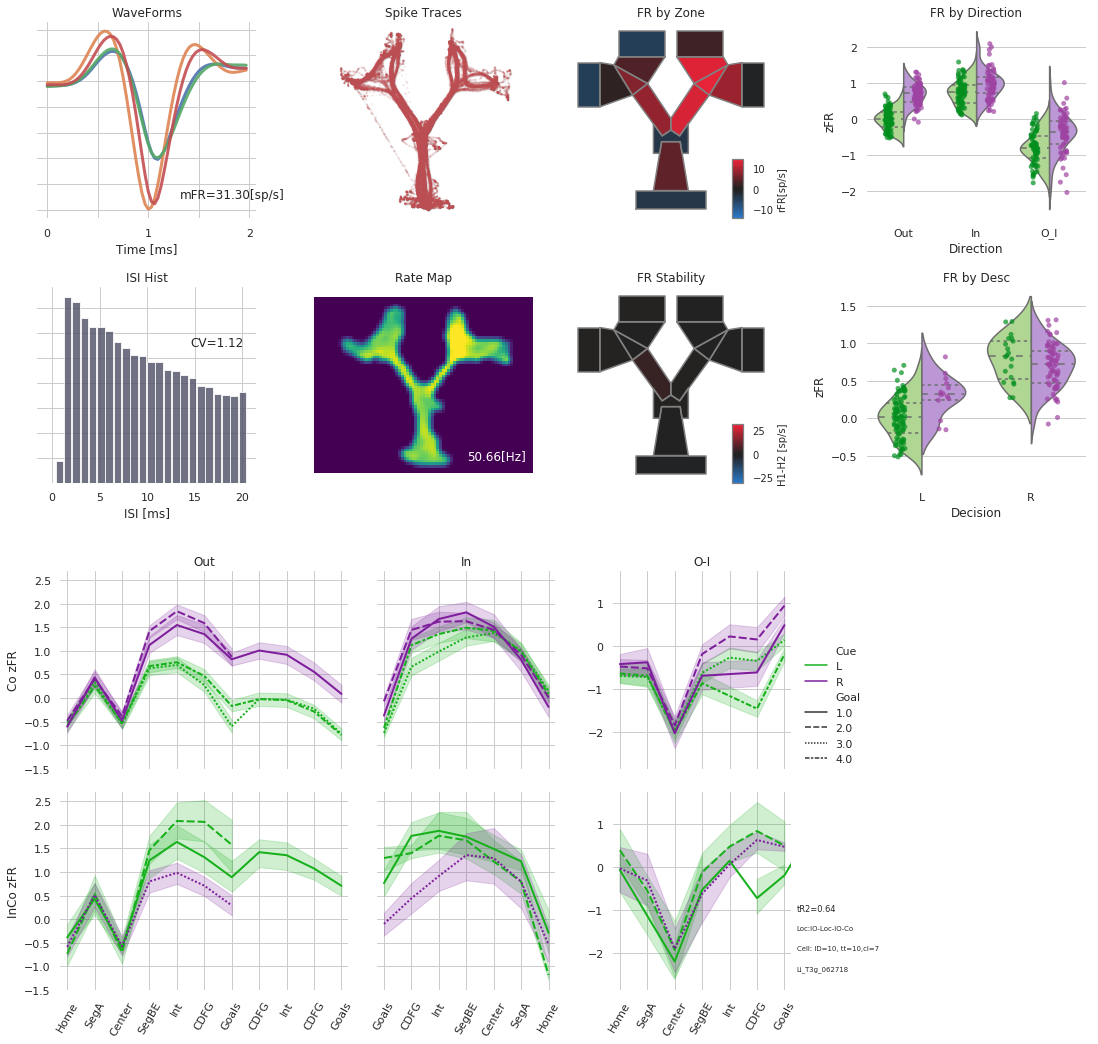

In [930]:
posdat = dat['PosDat']
trDat = dat['TrialLongMat']
occ = dat['za']['OccInfo']
nCells = len(dat['ids']['cells'])
nMua = len(dat['ids']['muas'])
nUnits = nCells+nMua

unitNum=10

if unitNum<nCells:
    ut = 'Cell'
    tt = dat['ids']['cells'][str(unitNum)][0]
    cl = dat['ids']['cells'][str(unitNum)][1]
    fr = dat['TrialFRLongMat']['cell_'+str(unitNum)]
    wfi = dat['wfi']['Cell'][unitNum]
    binSp = dat['bin_spikes']['Cell'][unitNum]

    mFR = dat['wfi']['Cell'][unitNum]['mFR']
    rZoneFR = dat['za']['FR_Zone']['Cells'][unitNum].loc['All']-mFR
    ZoneStabFR =  dat['za']['FR_Zone']['Cells'][unitNum].loc['H1']-dat['za']['FR_Zone']['Cells'][unitNum].loc['H2']


    tR2 = dat['TrialModelFits']['testR2'][unitNum]
    selMod = dat['TrialModelFits']['selMod'][unitNum]

else:
    ut = 'Mua'
    muaId = unitNum-nCells
    tt = dat['ids']['muas'][str(muaId)][0]
    cl = dat['ids']['muas'][str(muaId)][1]
    fr = dat['TrialFRLongMat']['mua_'+str(muaId)] 
    wfi = dat['wfi']['Mua'][muaId]
    binSp = dat['bin_spikes']['Mua'][muaId]


    mFR = dat['wfi']['Mua'][unitNum]['mFR']
    rZoneFR = dat['za']['FR_Zone']['Mua'][muaId].loc['All']-mFR
    ZoneStabFR =  dat['za']['FR_Zone']['Mua'][muaId].loc['H1']-dat['za']['FR_Zone']['Mua'][muaId].loc['H2']

    tR2 = dat['TrialModelFits']['testR2'][unitNum]
    selMod = dat['TrialModelFits']['selMod'][unitNum]


f = plt.figure(figsize=(16,16))

sns.set(style="whitegrid",font_scale=1,rc={
    'axes.spines.bottom': False,
'axes.spines.left': False,
'axes.spines.right': False,
'axes.spines.top': False,
'axes.edgecolor':'0.5'})


yorig = 0.42
w = 0.19
hsp = 0.05
vsp = 0.06
h = 0.17
yPos = np.array([vsp,2*vsp+h])+yorig
#xPos = np.arange(1,5)*hsp+np.arange(0,4)*w
xPos = [hsp, 2*hsp+w, 2.5*hsp+2*w, 4*hsp+3*w]
ax_top = {}
cnt=0
for i in np.arange(2):
    ax_top[i] = {}
    for j in np.arange(4):
        ax_top[i][j]=f.add_subplot(241+cnt)
        ax_top[i][j].set_position([xPos[j],yPos[i],w,h])
        cnt+=1
        #
        #print([xPos[j],yPos[i],W[j],h])


plotSpikeWFs(wfi,ax=ax_top[1][0])
plotISIh(wfi,ax=ax_top[0][0])

plotTracesSpikes(posdat,binSp,ax=ax_top[1][1])
plotRateMap(binSp,posdat,occ,ax=ax_top[0][1])

leg_ax = {'size':10}
_,cax=plotZoneAvgMaps(rZoneFR,ax=ax_top[1][2])
cax.set_ylabel('rFR[sp/s]',**leg_ax)
for label in (cax.get_yticklabels()):
    label.set_fontsize(10) # Size here overrides font_prop
ax_top[1][2].set_title('FR by Zone')

_,cax=plotZoneAvgMaps(ZoneStabFR,vmax=mFR,ax=ax_top[0][2])
cax.set_ylabel('H1-H2 [sp/s]',**leg_ax)
for label in (cax.get_yticklabels()):
    label.set_fontsize(10) # Size here overrides font_prop
ax_top[0][2].set_title('FR Stability')

plotTrial_Desc(fr,trDat,ax=ax_top[0][3])
ax_top[0][3].set_title('FR by Desc')
plotTrial_IO(fr,trDat,ax=ax_top[1][3])
ax_top[1][3].set_title('FR by Direction')

f,ax_bot=plot_TrLinearized(fr,trDat,pos=[0.02,0.02,1,0.4],f=f)
ax_bot[0][2].text(1.03,0.4,'tR2={0:0.2f}'.format(tR2),transform=ax_bot[0][2].transAxes,fontsize ='x-small')
ax_bot[0][2].text(1.03,0.3,'{}'.format(selMod),transform=ax_bot[0][2].transAxes,fontsize ='xx-small')
ax_bot[0][2].text(1.03,0.2,'{}: ID={}, tt={},cl={}'.format(ut,unitNum,tt,cl),transform=ax_bot[0][2].transAxes,fontsize ='xx-small')
ax_bot[0][2].text(1.03,0.1,se,transform=ax_bot[0][2].transAxes,fontsize ='xx-small')

sp = savePath/selMod
sp.mkdir(parents=True,exist_ok=True)

fn = '{}_ID-{}.jpeg'.format(se,unitNum)
f.savefig(str(sp/fn),dpi=150, bbox_inches='tight',pad_inches=0.2)
plt.close(f)